In [1]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import iqr
data = pd.read_csv("/Users/shreyamishra/Desktop/NSSO68 (3).csv")
df = data[data['state_1'] == 'GOA']
print("Dataset Information:")
print(df.columns)
print(df.head())
print(df.shape)

/var/folders/zv/szg3n90n0kgf4rs9_v41pm2m0000gn/T/ipykernel_13439/2117881353.py:6: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv("/Users/shreyamishra/Desktop/NSSO68 (3).csv")


Dataset Information:
Index(['slno', 'grp', 'Round_Centre', 'FSU_number', 'Round', 'Schedule_Number',
       'Sample', 'Sector', 'state', 'State_Region',
       ...
       'pickle_v', 'sauce_jam_v', 'Othrprocessed_v', 'Beveragestotal_v',
       'foodtotal_v', 'foodtotal_q', 'state_1', 'Region', 'fruits_df_tt_v',
       'fv_tot'],
      dtype='object', length=384)
        slno                                 grp  Round_Centre  FSU_number  \
22949  22950  46099999999999994133134266335232.0             1       46100   
22950  22951  46099999999999994133134266335232.0             1       46100   
22951  22952  46099999999999994133134266335232.0             1       46100   
22952  22953  46099999999999994133134266335232.0             1       46100   
22953  22954  46099999999999994133134266335232.0             1       46100   

       Round  Schedule_Number  Sample  Sector  state  State_Region  ...  \
22949     68               10       1       2     30           301  ...   
22950     68    

In [2]:
missing_info = df.isnull().sum()
print("Missing Values Information:")
print(missing_info)

Missing Values Information:
slno              0
grp               0
Round_Centre      0
FSU_number        0
Round             0
                 ..
foodtotal_q       0
state_1           0
Region            0
fruits_df_tt_v    0
fv_tot            0
Length: 384, dtype: int64


In [4]:
goanew = df[['state_1', 'District', 'Region', 'Sector', 'State_Region', 'Meals_At_Home', 'ricepds_v', 'Wheatpds_q', 'chicken_q', 'pulsep_q', 'wheatos_q', 'No_of_Meals_per_day']]
goanew['Meals_At_Home'].fillna(goanew['Meals_At_Home'].mean(), inplace=True)

/var/folders/zv/szg3n90n0kgf4rs9_v41pm2m0000gn/T/ipykernel_13439/393454667.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  goanew['Meals_At_Home'].fillna(goanew['Meals_At_Home'].mean(), inplace=True)


In [5]:
def remove_outliers(df, column_name):
    Q1 = df[column_name].quantile(0.25)
    Q3 = df[column_name].quantile(0.75)
    IQR = Q3 - Q1
    lower_threshold = Q1 - (1.5 * IQR)
    upper_threshold = Q3 + (1.5 * IQR)
    df = df[(df[column_name] >= lower_threshold) & (df[column_name] <= upper_threshold)]
    return df

outlier_columns = ['ricepds_v', 'chicken_q']
for col in outlier_columns:
    goanew = remove_outliers(goanew, col)
goanew['total_consumption'] = goanew[['ricepds_v', 'Wheatpds_q', 'chicken_q', 'pulsep_q', 'wheatos_q']].sum(axis=1)
def summarize_consumption(df, group_col):
    summary = df.groupby(group_col)['total_consumption'].sum().reset_index().sort_values(by='total_consumption', ascending=False)
    return summary
district_summary = summarize_consumption(goanew, 'District')
region_summary = summarize_consumption(goanew, 'Region')

print("Top Consuming Districts:")
print(district_summary.head(4))
print("Region Consumption Summary:")
print(region_summary)

Top Consuming Districts:
   District  total_consumption
0         1        3412.581508
1         2        3371.946528
Region Consumption Summary:
   Region  total_consumption
0       1        6784.528036


In [6]:
district_mapping = {"1" : "North Goa", "2" : "South Goa"}
sector_mapping = {"2": "URBAN", "1": "RURAL"}


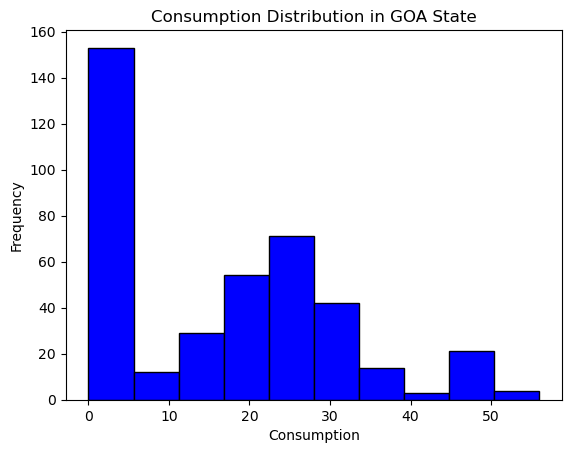

In [7]:
goanew['District'] = goanew['District'].astype(str).map(district_mapping).fillna(goanew['District'])
goanew['Sector'] = goanew['Sector'].astype(str).map(sector_mapping).fillna(goanew['Sector'])
plt.hist(goanew['total_consumption'], bins=10, color='blue', edgecolor='black')
plt.xlabel('Consumption')
plt.ylabel('Frequency')
plt.title('Consumption Distribution in GOA State')
plt.show()

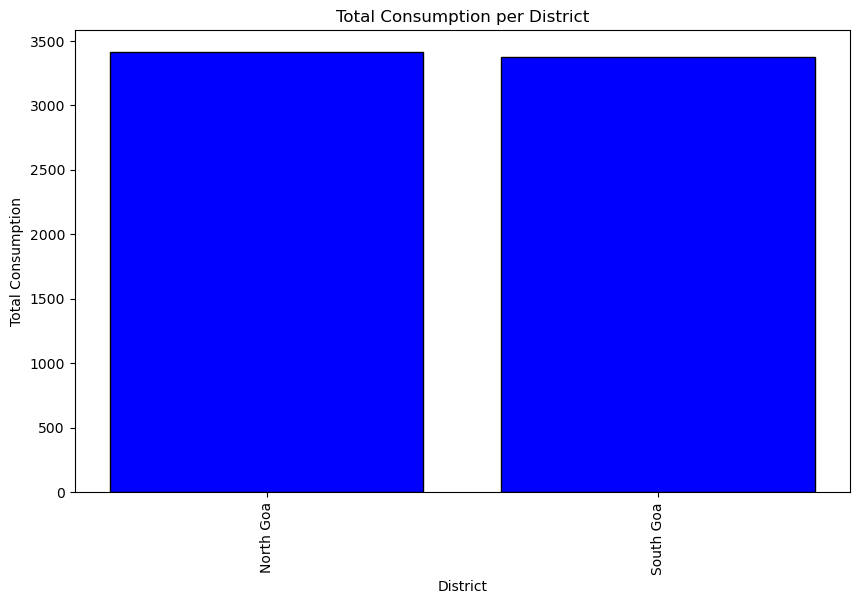

In [8]:
goa_consumption = goanew.groupby('District')['total_consumption'].sum().reset_index()

plt.figure(figsize=(10, 6))
plt.bar(goa_consumption['District'], goa_consumption['total_consumption'], color='blue', edgecolor='black')
plt.xlabel('District')
plt.ylabel('Total Consumption')
plt.title('Total Consumption per District')
plt.xticks(rotation=90)
plt.show()

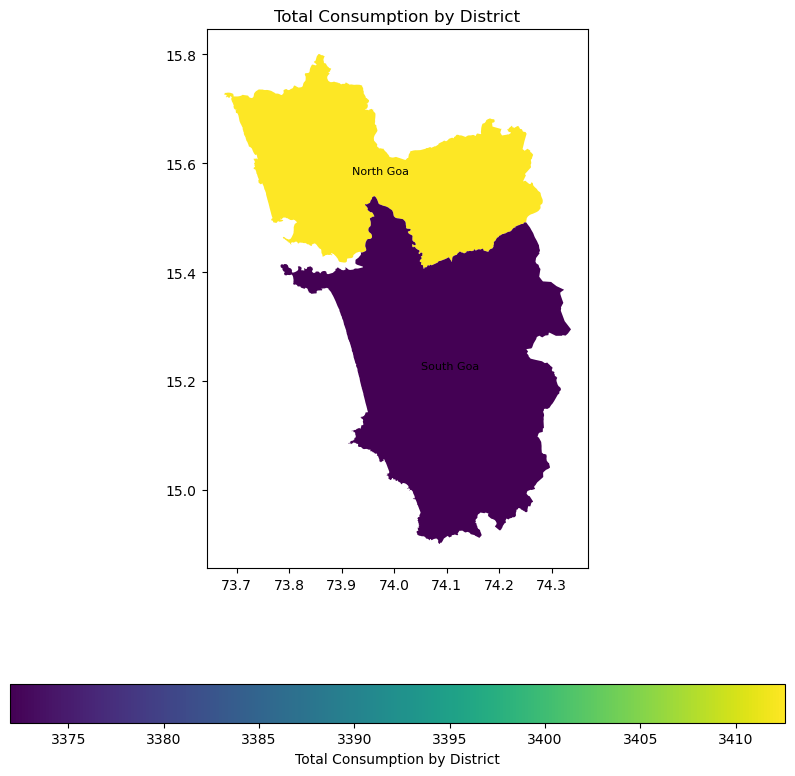

In [9]:
data_map = gpd.read_file("/Users/shreyamishra/Desktop/GOA_DISTRICTS.geojson")
data_map = data_map.rename(columns={'dtname': 'District'})
data_map_data = data_map.merge(goa_consumption, on='District')
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
data_map_data.plot(column='total_consumption', ax=ax, legend=True, legend_kwds={'label': "Total Consumption by District",
                        'orientation': "horizontal"})
data_map_data.apply(lambda x: ax.annotate(text=x.District, xy=x.geometry.centroid.coords[0], ha='center', fontsize=8, color='black'), axis=1)
plt.title("Total Consumption by District")
plt.show()
